<a href="https://colab.research.google.com/github/chrisliii/FINE-452/blob/main/M%26A_CAPM_FF3_Monthly.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Modules

In [1]:
!pip install yfinance

import yfinance as yf
import pandas as pd
import numpy as np
from datetime import datetime
from dateutil.relativedelta import relativedelta
import statsmodels.api as sm
import matplotlib.pyplot as plt

     |████████████████████████████████| 5.5MB 7.4MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.55-py2.py3-none-any.whl size=22618 sha256=3e52af9addd95f64f024b1132205edc99275607d7fc24ef9ee8276be30bf5a4f
  Stored in directory: /root/.cache/pip/wheels/04/98/cc/2702a4242d60bdc14f48b4557c427ded1fe92aedf257d4565c
Successfully built yfinance
  Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Data Prep

In [2]:
stock_name = "BUD"
ticker = yf.Ticker(stock_name)
#ticker.info
# monthly data
df_ticker_monthly_return = ticker.history(period="max", interval='1mo')
# process Dividends
df_ticker_monthly_return = df_ticker_monthly_return.dropna(how='all')
df_ticker_monthly_return['Dividends'] = df_ticker_monthly_return['Dividends'].shift(1)
df_ticker_monthly_return = df_ticker_monthly_return.dropna()
# monthly return
df_ticker_monthly_return['MonthlyReturn'] = 100*( (df_ticker_monthly_return['Close'].shift(-1)+df_ticker_monthly_return['Dividends'].shift(-1)).div(df_ticker_monthly_return['Close']) - 1)
df_ticker_monthly_return = df_ticker_monthly_return.dropna()
#date to string
df_ticker_monthly_return = df_ticker_monthly_return.reset_index()
df_ticker_monthly_return['Date'] = df_ticker_monthly_return['Date'].apply(lambda x: x.strftime('%Y%m'))

df_ticker_monthly_return.head(5)

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,MonthlyReturn
0,200908,29.760850,32.774607,28.668363,32.699265,552600.0,0.0,0,5.852542
1,200909,32.021172,36.097279,31.192390,34.613003,5235600.0,0.0,0,2.699174
2,200910,33.859563,39.585703,32.714334,35.547268,6638200.0,0.0,0,6.591756
3,200911,36.089738,39.593228,34.869164,37.890457,9535400.0,0.0,0,3.459936
4,200912,38.425401,40.452152,37.860322,39.201443,4094100.0,0.0,0,-4.305204


In [3]:
df_FF_Research = pd.read_csv('F-F_Research_Data_Factors.CSV', encoding="utf-8", skipinitialspace=True)
df_FF_Research.columns = ['Date', 'Mkt-RF', 'SMB', 'HML', 'RF']
df_FF_Research = df_FF_Research.dropna()
df_FF_Research['Date'] = df_FF_Research['Date'].shift(1)
df_FF_Research = df_FF_Research.dropna()
df_FF_Research['RF'] = df_FF_Research['RF'].astype(float)
df_FF_Research['Mkt-RF'] = df_FF_Research['Mkt-RF'].astype(float)
df_FF_Research['SMB'] = df_FF_Research['SMB'].astype(float)
df_FF_Research['HML'] = df_FF_Research['HML'].astype(float)

df_FF_Research.head()

,Date,Mkt-RF,SMB,HML,RF
1,192607,2.64,-1.40,4.19,0.25
2,192608,0.36,-1.32,0.01,0.23
3,192609,-3.24,0.04,0.51,0.32
4,192610,2.53,-0.20,-0.35,0.31
5,192611,2.62,-0.04,-0.02,0.28


### CAPM

#### CAPM Rolling Regression

In [ ]:
# past period rolling

# data prep
df_ticker_FF = pd.merge(df_ticker_monthly_return, df_FF_Research, on='Date')
df_ticker_FF['Date'] = pd.to_datetime(df_ticker_FF['Date'], format='%Y%m')

# sample period
begin_date = datetime(2010, 10, 1)
end_date = datetime(2020, 7, 1)
sample_period = 36

# CAPM out of sample
sample_date = begin_date
while sample_date <= end_date:
  df_ticker_FF_sample = df_ticker_FF[(df_ticker_FF.Date >= (sample_date - relativedelta(months=sample_period)) ) & 
                                     (df_ticker_FF.Date < sample_date)].copy()
  CAPM_model = sm.OLS(df_ticker_FF_sample['MonthlyReturn'], sm.add_constant(df_ticker_FF_sample[['Mkt-RF']].values))
  CAPM_result = CAPM_model.fit()
  #print(stock_name + '\n')
  #print (result.params)
  #print(CAPM_result.summary())

  # predict 
  sample_input = df_ticker_FF[(df_ticker_FF.Date == sample_date)]
  sample_input = sample_input['Mkt-RF'].values[0]
  sample_pred =  CAPM_result.predict([1,sample_input])
  #print(sample_input)
  #print(sample_pred)
  df_ticker_FF.loc[df_ticker_FF.Date == sample_date, 'PredReturn'] = sample_pred[0]

  # next sample
  sample_date = sample_date + relativedelta(months=1)


df_ticker_FF = df_ticker_FF.dropna()

df_ticker_FF.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,MonthlyReturn,Mkt-RF,SMB,HML,RF,PredReturn
423,2010-10-01,37.358292,38.802091,36.228361,37.060116,23048500.0,0.00,0.0,0.889277,3.88,1.13,-2.61,0.01,0.247393
424,2010-11-01,37.107200,39.586767,36.950265,37.389683,23150700.0,0.00,0.0,6.677382,0.60,3.71,-0.90,0.01,0.468145
425,2010-12-01,38.028079,40.332334,37.775558,39.606335,17055000.0,0.28,0.0,-6.614860,6.82,0.68,3.81,0.01,0.712158
426,2011-01-01,39.803618,39.803618,36.607650,36.986431,23546400.0,0.00,0.0,-2.432236,1.99,-2.47,0.81,0.01,0.843717
427,2011-02-01,37.167939,38.201698,35.124097,36.086834,26559300.0,0.00,0.0,3.950818,3.49,1.53,1.09,0.01,0.414616


#### CAPM Cumulative Regression

In [4]:
# past period accumulative

# data prep
df_ticker_FF = pd.merge(df_ticker_monthly_return, df_FF_Research, on='Date')
df_ticker_FF['Date'] = pd.to_datetime(df_ticker_FF['Date'], format='%Y%m')

# sample period
begin_date = datetime(2010, 10, 1)
end_date = datetime(2020, 7, 1)
sample_period = 60

# CAPM out of sample
sample_date = begin_date
while sample_date <= end_date:
  df_ticker_FF_sample = df_ticker_FF[(df_ticker_FF.Date >= (begin_date - relativedelta(months=sample_period)) ) & 
                                     (df_ticker_FF.Date < sample_date)].copy()
  CAPM_model = sm.OLS(df_ticker_FF_sample['MonthlyReturn'], sm.add_constant(df_ticker_FF_sample[['Mkt-RF']].values))
  CAPM_result = CAPM_model.fit()
  #print(stock_name + '\n')
  #print (result.params)
  #print(CAPM_result.summary())

  # predict 
  sample_input = df_ticker_FF[(df_ticker_FF.Date == sample_date)]
  sample_input = sample_input['Mkt-RF'].values[0]
  sample_pred =  CAPM_result.predict([1,sample_input])
  #print(sample_input)
  #print(sample_pred)
  df_ticker_FF.loc[df_ticker_FF.Date == sample_date, 'PredReturn'] = sample_pred[0]

  # next sample
  sample_date = sample_date + relativedelta(months=1)


df_ticker_FF = df_ticker_FF.dropna()

df_ticker_FF.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,MonthlyReturn,Mkt-RF,SMB,HML,RF,PredReturn
14,2010-10-01,44.997546,49.322913,43.642062,47.898895,25527800.0,0.0,0,-12.655020,0.60,3.71,-0.90,0.01,2.437812
15,2010-11-01,48.195879,48.599477,41.479373,41.837280,24626900.0,0.0,0,3.913373,6.82,0.68,3.81,0.01,5.633195
16,2010-12-01,42.507413,44.548256,42.400802,43.474529,20067700.0,0.0,0,-3.117881,1.99,-2.47,0.81,0.01,2.237493
17,2011-01-01,43.885745,44.837631,41.814441,42.119045,19419700.0,0.0,0,1.301727,3.49,1.53,1.09,0.01,2.903133
18,2011-02-01,42.294183,43.261299,41.426063,42.667320,30938900.0,0.0,0,2.034648,0.45,2.60,-1.58,0.01,0.834249


#### CAPM Epsilon

In [5]:
df_ticker_FF['Epsilon'] = df_ticker_FF.MonthlyReturn - df_ticker_FF.RF - df_ticker_FF.PredReturn
# RollingSumEpsilon
df_ticker_FF['RollingSumEpsilon'] = df_ticker_FF.Epsilon.rolling(20).sum()
# CumSumEpsilon
for date in df_ticker_FF[df_ticker_FF.Date >= begin_date + relativedelta(months=12)].Date.tolist():
  df_ticker_FF.loc[df_ticker_FF.Date == date, 'CumSumEpsilon'] = df_ticker_FF[df_ticker_FF.Date <= date].Epsilon.sum()

df_ticker_FF['AbsEpsilon'] = abs(df_ticker_FF['Epsilon'])
# RollingAvgAbsEpsilon
df_ticker_FF['RollingAvgAbsEpsilon'] = df_ticker_FF.AbsEpsilon.rolling(20).mean()
# CumAvgAbsEpsilon
for date in df_ticker_FF[df_ticker_FF.Date >= begin_date + relativedelta(months=12)].Date.tolist():
  df_ticker_FF.loc[df_ticker_FF.Date == date, 'CumAvgAbsEpsilon'] = df_ticker_FF[df_ticker_FF.Date <= date].AbsEpsilon.mean()

df_ticker_FF.tail()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,MonthlyReturn,Mkt-RF,SMB,HML,RF,PredReturn,Epsilon,RollingSumEpsilon,CumSumEpsilon,AbsEpsilon,RollingAvgAbsEpsilon,CumAvgAbsEpsilon
127,2020-03-01,56.917395,58.085846,32.261114,43.688160,111428900.0,0.000000,0,5.439713,13.65,2.76,-1.18,0.00,13.903590,-8.463877,-60.185404,-131.149029,8.463877,7.016660,4.628460
128,2020-04-01,43.945617,49.451194,40.707623,46.064671,54805900.0,0.000000,0,0.773868,5.58,2.46,-4.92,0.01,5.253739,-4.489872,-57.888528,-135.638901,4.489872,6.901816,4.627254
129,2020-05-01,45.945849,47.876760,37.558750,46.421150,63892800.0,0.000000,0,5.162106,2.45,2.68,-2.19,0.01,2.118040,3.034066,-43.996807,-132.604835,3.034066,6.510637,4.613520
130,2020-06-01,47.361850,58.085846,46.995469,48.817459,70354500.0,0.000000,0,12.658279,5.77,-2.31,-1.27,0.01,5.395436,7.252843,-38.904332,-125.351993,7.252843,6.765260,4.636078
131,2020-07-01,48.410000,58.549999,48.410000,54.430000,45817800.0,0.566909,0,6.834468,29.47,-2.46,-3.75,3.12,29.094188,-25.379719,-58.915775,-150.731712,25.379719,7.765832,4.811872


#### CAPM Plot 6 subplots

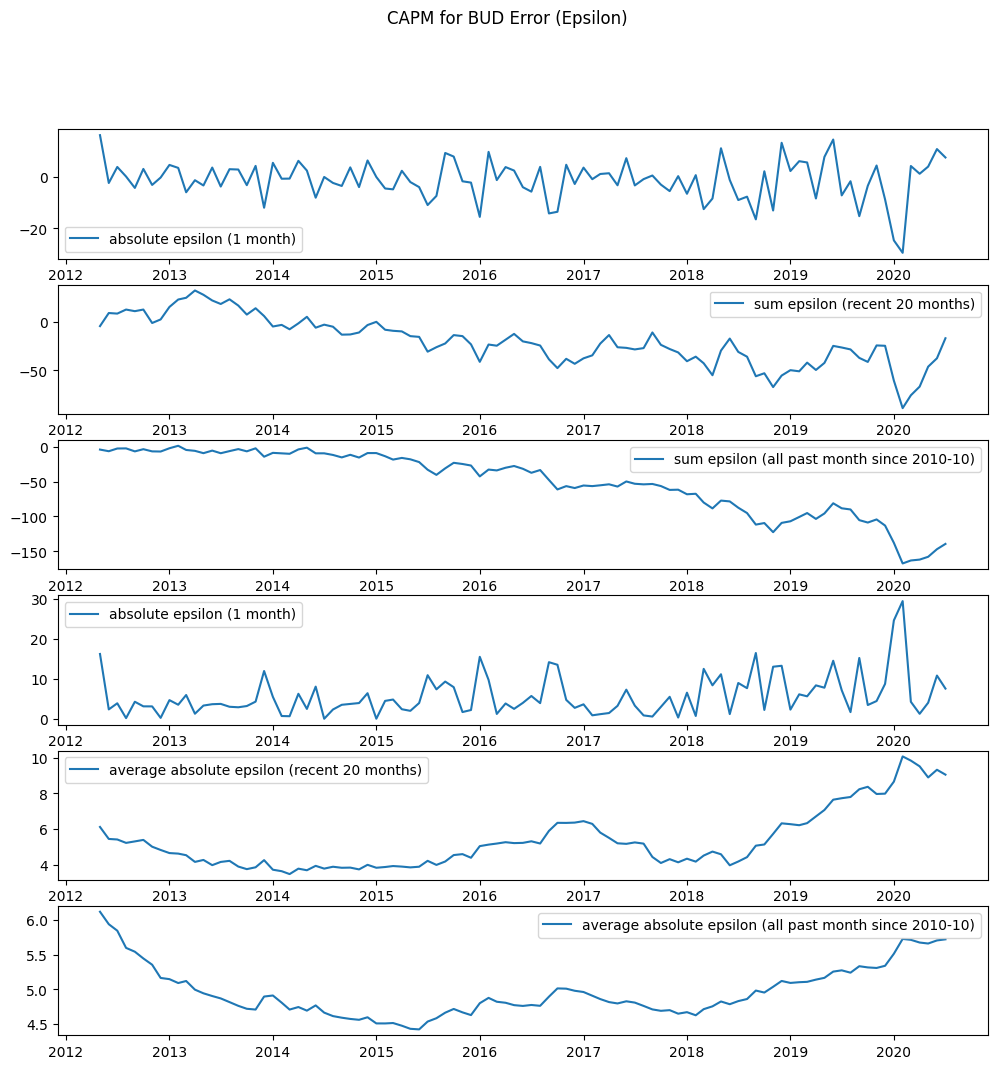

In [ ]:
df_ticker_FF = df_ticker_FF.dropna()

fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(6, dpi=100, figsize=(12,12))
fig.suptitle('CAPM for '+ stock_name +' Error (Epsilon)')
ax1.plot(df_ticker_FF.Date, df_ticker_FF.Epsilon, label='absolute epsilon (1 month)')
ax1.legend()
ax2.plot(df_ticker_FF.Date, df_ticker_FF.RollingSumEpsilon, label='sum epsilon (recent 20 months)')
ax2.legend()
ax3.plot(df_ticker_FF.Date, df_ticker_FF.CumSumEpsilon, label='sum epsilon (all past month since 2010-10)')
ax3.legend()
ax4.plot(df_ticker_FF.Date, df_ticker_FF.AbsEpsilon, label='absolute epsilon (1 month)')
ax4.legend()
ax5.plot(df_ticker_FF.Date, df_ticker_FF.RollingAvgAbsEpsilon, label='average absolute epsilon (recent 20 months)')
ax5.legend()
ax6.plot(df_ticker_FF.Date, df_ticker_FF.CumAvgAbsEpsilon, label='average absolute epsilon (all past month since 2010-10)')
ax6.legend()

#### CAPM Plot 3 subplots

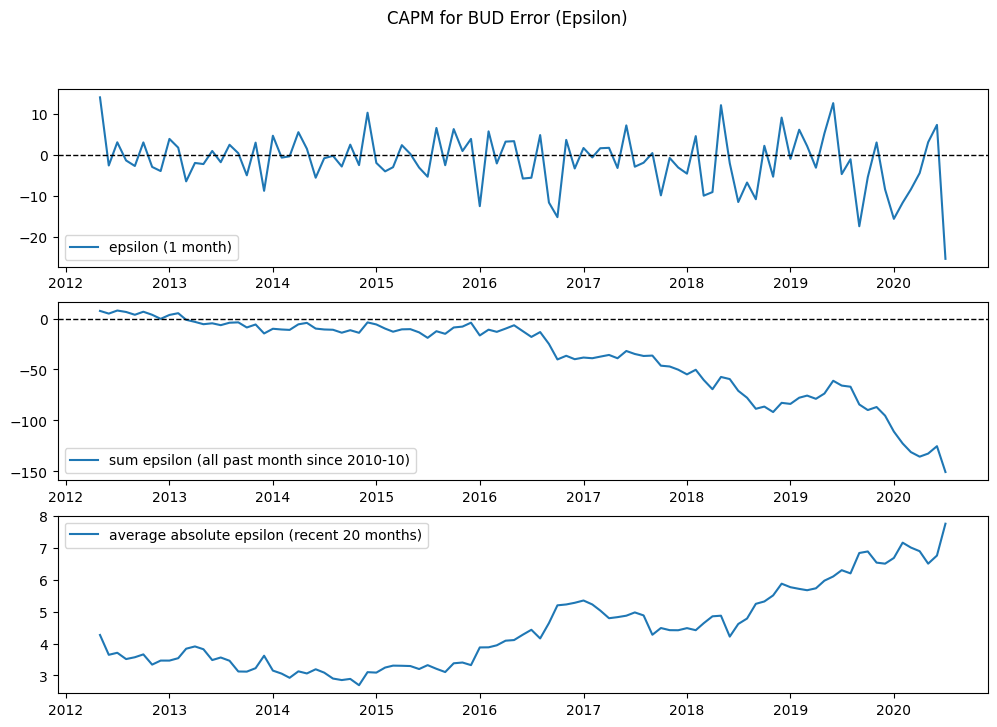

In [6]:
df_ticker_FF = df_ticker_FF.dropna()

fig, (ax1, ax2, ax3) = plt.subplots(3, dpi=100, figsize=(12,8))
fig.suptitle('CAPM for '+ stock_name +' Error (Epsilon)')
ax1.plot(df_ticker_FF.Date, df_ticker_FF.Epsilon, label='epsilon (1 month)')
ax1.axhline(y=0, linewidth=1, color='black', linestyle='--')
ax1.legend()
ax2.plot(df_ticker_FF.Date, df_ticker_FF.CumSumEpsilon, label='sum epsilon (all past month since 2010-10)')
ax2.axhline(y=0, linewidth=1, color='black', linestyle='--')
ax2.legend()
ax3.plot(df_ticker_FF.Date, df_ticker_FF.RollingAvgAbsEpsilon, label='average absolute epsilon (recent 20 months)')
ax3.legend()

### FF3

#### FF3 Cumulative Regression

In [7]:
# past period accumulative

# data prep
df_ticker_FF = pd.merge(df_ticker_monthly_return, df_FF_Research, on='Date')
df_ticker_FF['Date'] = pd.to_datetime(df_ticker_FF['Date'], format='%Y%m')

# sample period
begin_date = datetime(2010, 10, 1)
end_date = datetime(2020, 7, 1)
sample_period = 120

# FF3 out of sample
sample_date = begin_date
while sample_date <= end_date:
  df_ticker_FF_sample = df_ticker_FF[(df_ticker_FF.Date >= (begin_date - relativedelta(months=sample_period)) ) & 
                                     (df_ticker_FF.Date < sample_date)].copy()
  FF3_model = sm.OLS(df_ticker_FF_sample['MonthlyReturn'], 
                      sm.add_constant(df_ticker_FF_sample[['Mkt-RF', 'SMB', 'HML']].values))
  FF3_result = FF3_model.fit()
  #print(stock_name + '\n')
  #print (FF3_result.params)
  #print(FF3_result.summary())

  # predict 
  sample_input = df_ticker_FF[(df_ticker_FF.Date == sample_date)]
  sample_input = sample_input[['Mkt-RF', 'SMB', 'HML']].values[0].tolist()
  sample_pred =  FF3_result.predict([1] + sample_input)
  #print(sample_input)
  #print(sample_pred)
  df_ticker_FF.loc[df_ticker_FF.Date == sample_date, 'PredReturn'] = sample_pred[0]

  # next sample
  sample_date = sample_date + relativedelta(months=1)


df_ticker_FF = df_ticker_FF.dropna()

df_ticker_FF.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,MonthlyReturn,Mkt-RF,SMB,HML,RF,PredReturn
14,2010-10-01,44.997546,49.322913,43.642062,47.898895,25527800.0,0.0,0,-12.655020,0.60,3.71,-0.90,0.01,2.546199
15,2010-11-01,48.195879,48.599477,41.479373,41.837280,24626900.0,0.0,0,3.913373,6.82,0.68,3.81,0.01,2.388605
16,2010-12-01,42.507413,44.548256,42.400802,43.474529,20067700.0,0.0,0,-3.117881,1.99,-2.47,0.81,0.01,2.806732
17,2011-01-01,43.885745,44.837631,41.814441,42.119045,19419700.0,0.0,0,1.301727,3.49,1.53,1.09,0.01,1.483041
18,2011-02-01,42.294183,43.261299,41.426063,42.667320,30938900.0,0.0,0,2.034648,0.45,2.60,-1.58,0.01,1.256042


#### FF3 Epsilon

In [8]:
df_ticker_FF['Epsilon'] = df_ticker_FF.MonthlyReturn - df_ticker_FF.RF - df_ticker_FF.PredReturn
# RollingSumEpsilon
df_ticker_FF['RollingSumEpsilon'] = df_ticker_FF.Epsilon.rolling(20).sum()
# CumSumEpsilon
for date in df_ticker_FF[df_ticker_FF.Date >= begin_date + relativedelta(months=12)].Date.tolist():
  df_ticker_FF.loc[df_ticker_FF.Date == date, 'CumSumEpsilon'] = df_ticker_FF[df_ticker_FF.Date <= date].Epsilon.sum()

df_ticker_FF['AbsEpsilon'] = abs(df_ticker_FF['Epsilon'])
# RollingAvgAbsEpsilon
df_ticker_FF['RollingAvgAbsEpsilon'] = df_ticker_FF.AbsEpsilon.rolling(20).mean()
# CumAvgAbsEpsilon
for date in df_ticker_FF[df_ticker_FF.Date >= begin_date + relativedelta(months=12)].Date.tolist():
  df_ticker_FF.loc[df_ticker_FF.Date == date, 'CumAvgAbsEpsilon'] = df_ticker_FF[df_ticker_FF.Date <= date].AbsEpsilon.mean()

df_ticker_FF.tail()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,MonthlyReturn,Mkt-RF,SMB,HML,RF,PredReturn,Epsilon,RollingSumEpsilon,CumSumEpsilon,AbsEpsilon,RollingAvgAbsEpsilon,CumAvgAbsEpsilon
127,2020-03-01,56.917395,58.085846,32.261114,43.688160,111428900.0,0.000000,0,5.439713,13.65,2.76,-1.18,0.00,14.216463,-8.776750,-75.044517,-147.128046,8.776750,7.767590,4.819528
128,2020-04-01,43.945617,49.451194,40.707623,46.064671,54805900.0,0.000000,0,0.773868,5.58,2.46,-4.92,0.01,5.094202,-4.330334,-71.368369,-151.458380,4.330334,7.583783,4.815274
129,2020-05-01,45.945849,47.876760,37.558750,46.421150,63892800.0,0.000000,0,5.162106,2.45,2.68,-2.19,0.01,1.421909,3.730197,-58.758980,-147.728183,3.730197,7.326333,4.805920
130,2020-06-01,47.361850,58.085846,46.995469,48.817459,70354500.0,0.000000,0,12.658279,5.77,-2.31,-1.27,0.01,6.465848,6.182431,-54.815276,-141.545752,6.182431,7.523518,4.817685
131,2020-07-01,48.410000,58.549999,48.410000,54.430000,45817800.0,0.566909,0,6.834468,29.47,-2.46,-3.75,3.12,32.388107,-28.673638,-77.707581,-170.219390,28.673638,8.668133,5.019854


#### FF3 Plot 6 subplots

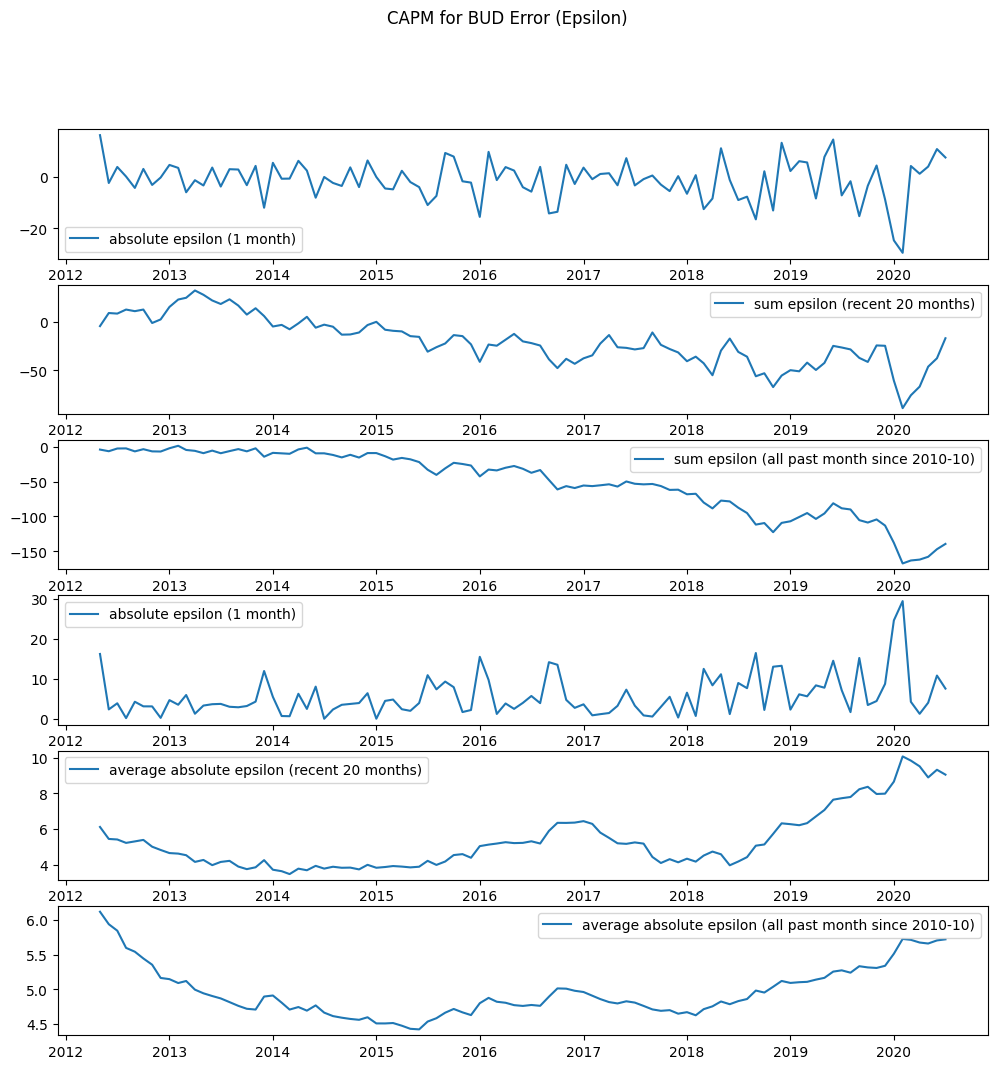

In [ ]:
df_ticker_FF = df_ticker_FF.dropna()

fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(6, dpi=100, figsize=(12,12))
fig.suptitle('FF3 for '+ stock_name +' Error (Epsilon)')
ax1.plot(df_ticker_FF.Date, df_ticker_FF.Epsilon, label='absolute epsilon (1 month)')
ax1.legend()
ax2.plot(df_ticker_FF.Date, df_ticker_FF.RollingSumEpsilon, label='sum epsilon (recent 20 months)')
ax2.legend()
ax3.plot(df_ticker_FF.Date, df_ticker_FF.CumSumEpsilon, label='sum epsilon (all past month since 2010-10)')
ax3.legend()
ax4.plot(df_ticker_FF.Date, df_ticker_FF.AbsEpsilon, label='absolute epsilon (1 month)')
ax4.legend()
ax5.plot(df_ticker_FF.Date, df_ticker_FF.RollingAvgAbsEpsilon, label='average absolute epsilon (recent 20 months)')
ax5.legend()
ax6.plot(df_ticker_FF.Date, df_ticker_FF.CumAvgAbsEpsilon, label='average absolute epsilon (all past month since 2010-10)')
ax6.legend()

#### FF3 Plot 3 subplots

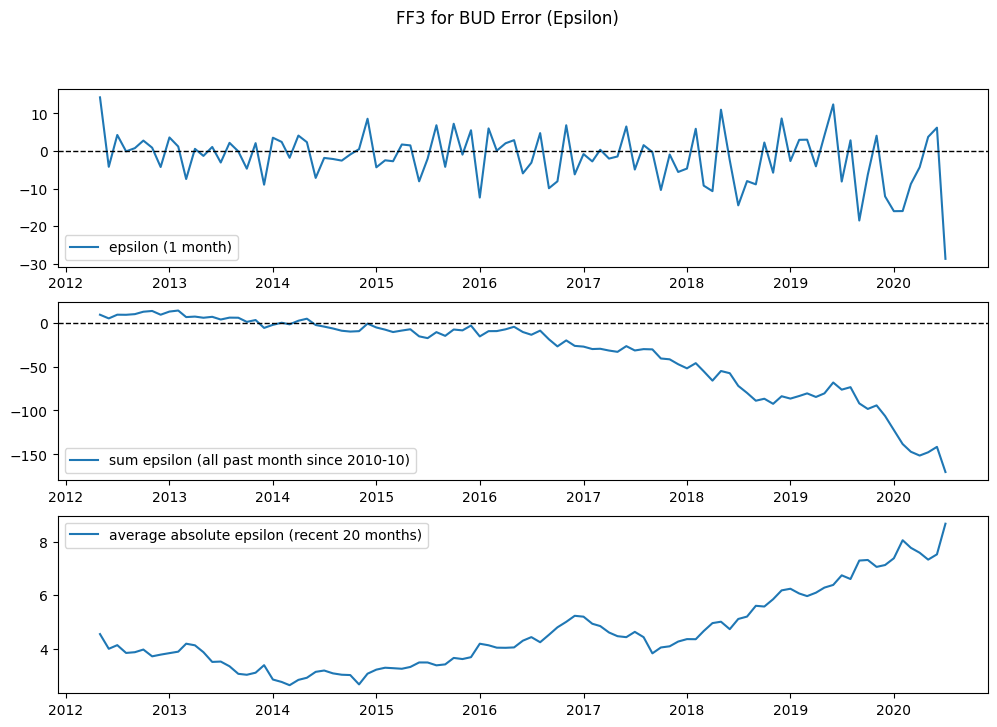

In [9]:
df_ticker_FF = df_ticker_FF.dropna()

fig, (ax1, ax2, ax3) = plt.subplots(3, dpi=100, figsize=(12,8))
fig.suptitle('FF3 for '+ stock_name +' Error (Epsilon)')
ax1.plot(df_ticker_FF.Date, df_ticker_FF.Epsilon, label='epsilon (1 month)')
ax1.axhline(y=0, linewidth=1, color='black', linestyle='--')
ax1.legend()
ax2.plot(df_ticker_FF.Date, df_ticker_FF.CumSumEpsilon, label='sum epsilon (all past month since 2010-10)')
ax2.axhline(y=0, linewidth=1, color='black', linestyle='--')
ax2.legend()
ax3.plot(df_ticker_FF.Date, df_ticker_FF.RollingAvgAbsEpsilon, label='average absolute epsilon (recent 20 months)')
ax3.legend()